In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import time
from scipy import signal
import warnings
from sklearn.preprocessing import minmax_scale
import heartpy as hp
warnings.filterwarnings('ignore')

In [3]:
source_dir = 'D:/Code/data/PLETH/'

rawdata_list = os.listdir(source_dir)
print(len(rawdata_list))

6157


In [4]:
Censoring    = 100 * 60 * 25  # 25 min, 데이터에서 앞의 25분과 뒤의 25분을 잘라내기 위한 상수값(hyper parameter)
DataSet      = []
ErrorTracker = []
SampleInfo   = []
RawSampleIDXList = []

path = 'D:/Code/data/'
ParaFolder = 'ValPLETH'

In [4]:
for idx, filename in enumerate(rawdata_list[:2000]):
    print(idx, ': ', filename)
    data = np.load(source_dir + filename, allow_pickle=True)['PLETH'][:,0][Censoring:-Censoring]

    # Nan 값 있는 index 선택,
    ExcCriteria = np.where(np.isnan(data))[0]
    ExcCriteria = np.concatenate([[0], ExcCriteria, [data.shape[0]]])
    IndMaxDif = ExcCriteria[1:] - ExcCriteria[:-1]
    IndMaxDif_enough = np.where(IndMaxDif>100*60*1)[0] # 1 분이상 연속시계열 확보 구간 선정

    if len(IndMaxDif_enough) <= 0: # OBS 확보 안되는 sample은 포함 시키지 않기
        print('Sample excluded due to small obs.')
        # ErrorTracker.append(str(idx)+' excluded due to small obs.')
        print()
        continue

    StartInd = ExcCriteria[IndMaxDif_enough][..., np.newaxis]
    EndInd = ExcCriteria[IndMaxDif_enough+1][..., np.newaxis]
    SelectedPeriod = np.concatenate([StartInd,EndInd], axis=-1)

    SampleIDXVec = np.full((SelectedPeriod.shape[0],1), idx)
    RawSampleIDX = np.concatenate([SampleIDXVec, (SelectedPeriod + Censoring)], axis=1)
    RawSampleIDXList.append(RawSampleIDX)

    for PeriodNum,Period in enumerate(SelectedPeriod):
        print('Sample-'+str(idx)+'-'+str(PeriodNum))
        # SampleInfo.append('Sample-'+str(idx)+'-'+str(PeriodNum))
        DataSet.append(data[Period[0]:Period[1]])
    print()

# np.save(path+ParaFolder+'/SampleInfo',SampleInfo)
# np.save(path+ParaFolder+'/ErrorTracker',ErrorTracker)
np.save(path+ParaFolder+'/DataSet',DataSet)
# np.save(path+ParaFolder+'/RawSampleIDX_raw',RawSampleIDXList)

0 :  1.npz
Sample-0-0

1 :  10.npz
Sample-1-0

2 :  100.npz
Sample-2-0

3 :  1000.npz
Sample-3-0

4 :  1001.npz
Sample-4-0

5 :  1002.npz
Sample-5-0

6 :  1003.npz
Sample-6-0

7 :  1004.npz
Sample-7-0
Sample-7-1

8 :  1005.npz
Sample-8-0
Sample-8-1

9 :  1006.npz
Sample-9-0

10 :  1007.npz
Sample-10-0

11 :  1008.npz
Sample-11-0

12 :  1009.npz
Sample-12-0

13 :  101.npz
Sample-13-0

14 :  1011.npz
Sample-14-0

15 :  1012.npz
Sample-15-0
Sample-15-1

16 :  1013.npz
Sample-16-0
Sample-16-1

17 :  1014.npz
Sample-17-0

18 :  1015.npz
Sample-18-0

19 :  1016.npz
Sample-19-0
Sample-19-1

20 :  1017.npz
Sample-20-0

21 :  1019.npz
Sample-21-0

22 :  102.npz
Sample-22-0
Sample-22-1

23 :  1020.npz
Sample-23-0

24 :  1021.npz
Sample-24-0
Sample-24-1

25 :  1022.npz
Sample-25-0
Sample-25-1

26 :  1023.npz
Sample-26-0

27 :  1024.npz
Sample-27-0
Sample-27-1

28 :  1025.npz
Sample-28-0
Sample-28-1

29 :  1026.npz
Sample-29-0
Sample-29-1
Sample-29-2
Sample-29-3

30 :  1027.npz
Sample-30-0
Sample-

In [63]:
DataSet = np.load(path+ParaFolder+'/DataSet3.npy',allow_pickle = True)
len(DataSet)

11425

In [64]:
def get_difference_list(seq):
    seq  = np.concatenate([[0], seq, [0]])
    differ = seq[1:] - seq[:-1]
    differ = differ[1:-1]
    return differ

In [65]:
def check_ppg_normal(ppg, sig_length=2500, fs=100):
    if (np.max(ppg) >= 100) or (np.min(ppg) <= 0):
        return 0

    PPG = minmax_scale(ppg)
    # Transpose the Signals if they are in column format, necessary for peak detection
    if PPG.shape[0] > 1:
        PPG = PPG.T

    try:
        wd_p, _ = hp.process(PPG, sample_rate=fs) # peak 검출
    except Exception:
        return 0

    # Peak
    pks_PPG = wd_p['peaklist'] # peak의 위치 리스트
    pks_PPG = np.array(pks_PPG)
    peak_dist_PPG = get_difference_list(pks_PPG) # peak 간격 리스트
    std_peak_dist_PPG = np.std(peak_dist_PPG) # peak 간격의 std, feature 1
    std_peaks_PPG = np.std(PPG[pks_PPG]) # peak 값의 std, feature 2
    num_peaks_PPG = len(pks_PPG) # peak 갯수, feature 3

    # peak 값들이 고르지 않거나, peak 간격이 고르지 않거나, peak 갯수가 길이에 비해 많거나 적을 경우 => bad signal
    if (std_peaks_PPG > 0.09) or (std_peak_dist_PPG > 11) or (num_peaks_PPG < int(sig_length/(fs*1.5))) or (num_peaks_PPG > int(sig_length/(fs*0.5))):
        return 0

    # 첫번째 peak가 너무 늦게 검출되거나, 마지막 peak가 너무 이르게 검출되면 => bad signal
    if (pks_PPG[0] > 1.5*np.mean(peak_dist_PPG)) or (sig_length - pks_PPG[-1] > 1.5*np.mean(peak_dist_PPG)):
        return 0

    # 추가 feature
    max_min_differ_pks = np.max(PPG[pks_PPG]) - np.min(PPG[pks_PPG]) # 최대 peak와 최소 peak 차이, feature 4
    differ_pks = get_difference_list(PPG[pks_PPG])
    max_differ_pks = max(np.abs(differ_pks)) # peak간 차분값의 최댓값, feature 5

    if (max_min_differ_pks > 0.19) or (max_differ_pks > 0.15):
        return 0

    if np.min(ppg[pks_PPG]) <= 41:
        return 0

    # Valley
    P2PIDX =  np.concatenate([pks_PPG[:-1][..., np.newaxis], pks_PPG[1:][..., np.newaxis] ], axis=-1)
    val_PPG =  np.unique([np.argmin(PPG[i[0]:i[1]]) +i[0]  for i in P2PIDX])

    valley_dist_PPG = get_difference_list(val_PPG) # valley 간격 리스트
    std_valley_dist_PPG = np.std(valley_dist_PPG) # valley 간격의 std
    std_valley_PPG = np.std(PPG[val_PPG]) # valley 값의 std
    num_valley_PPG = len(val_PPG) # valley 갯수

    # 첫값이 매우 작으면 bad signal
    if ppg[0] < (np.min(ppg[val_PPG])-5):
        return 0

    # valley 값들이 고르지 않거나, valley 간격이 고르지 않거나, valley 갯수가 길이에 비해 많거나 적을 경우 => bad signal
    if (std_valley_PPG > 0.085) or (std_valley_dist_PPG > 19) or (num_valley_PPG < int(sig_length/(fs*1.5))) or (num_valley_PPG > int(sig_length/(fs*0.5))):
        return 0

    # 첫번째 valley가 너무 늦게 검출되거나, 마지막 valley가 너무 이르게 검출되면 => bad signal
    if (val_PPG[0] > 1.4*np.mean(valley_dist_PPG)) or (sig_length - val_PPG[-1] > 1.5*np.mean(valley_dist_PPG)):
        return 0

    # 추가 feature
    max_min_differ_val = np.max(PPG[val_PPG]) - np.min(PPG[val_PPG]) # 최대 valley와 최소 valley 차이, feature 4
    differ_val = get_difference_list(PPG[val_PPG])
    max_differ_val = max(np.abs(differ_val)) # valley간 차분값의 최댓값, feature 5

    if (max_min_differ_val > 0.19) or (max_differ_val > 0.15):
        return 0

    if np.max(ppg[val_PPG]) >= 39:
        return 0

    # valley 고주파가 심한경우
    PPG_r = 1-PPG
    try:
        wd_p, _ = hp.process(PPG_r, sample_rate=100)
    except Exception:
        return 0

    pks_PPG_r = wd_p['peaklist']
    pks_PPG_r = np.array(pks_PPG_r)
    peak_dist_PPG_r = get_difference_list(pks_PPG_r)
    if np.std(peak_dist_PPG_r)>=25:
        return 0

    GradSignal = np.gradient(PPG)
    NegGradIDX = np.where(GradSignal<0)[0]
    NegGradIDX = np.delete(NegGradIDX,np.where(NegGradIDX==0)) # idx 0의 경우 제외
    gradient_convert = NegGradIDX[GradSignal[NegGradIDX-1]>=0]

    if len(gradient_convert)>=270:
        return 0

    return 1

In [66]:
def check_ppg_abnormal(ppg, sig_length=3500, fs=100):
    if (np.max(ppg) >= 100) or (np.min(ppg) <= 0):
        return {'result': 1, 'reason': '0~100 범위 초과'}

    PPG = minmax_scale(ppg)
    # Transpose the Signals if they are in column format, necessary for peak detection
    if PPG.shape[0] > 1:
        PPG = PPG.T

    try:
        wd_p, _ = hp.process(PPG, sample_rate=fs) # peak 검출
    except Exception:
        return {'result': 1, 'reason': 'heartpy 사용중 error'}

    # Peak
    pks_PPG = wd_p['peaklist'] # peak의 위치 리스트
    pks_PPG = np.array(pks_PPG)

    # Valley
    P2PIDX =  np.concatenate([pks_PPG[:-1][..., np.newaxis], pks_PPG[1:][..., np.newaxis] ], axis=-1)
    val_PPG =  np.unique([np.argmin(PPG[i[0]:i[1]]) +i[0]  for i in P2PIDX])

    if pks_PPG[-1] == (sig_length-1):
        pks_PPG = np.delete(pks_PPG,-1)

    peak_dist_PPG = get_difference_list(pks_PPG) # peak 간격 리스트
    std_peak_dist_PPG = np.std(peak_dist_PPG) # peak 간격의 std, feature 1
    std_peaks_PPG = np.std(PPG[pks_PPG]) # peak 값의 std, feature 2
    num_peaks_PPG = len(pks_PPG) # peak 갯수, feature 3


    # peak 값들이 고르지 않거나, peak 간격이 고르지 않거나, peak 갯수가 길이에 비해 많거나 적을 경우 => bad signal
    if (std_peaks_PPG > 0.2):
        return {'result': 1, 'reason': 'peak들의 std가 0.2 초과'}

    if (std_peak_dist_PPG > 19):
        return {'result': 1, 'reason': 'peak간격의 std가 19 초과'}

    if (num_peaks_PPG < int(sig_length/(fs*1.5))) or (num_peaks_PPG > int(sig_length/(fs*0.5))):
        return {'result': 1, 'reason': '박동이 너무 빠르거나 느림(peak)'}


    # 추가 feature
    max_min_differ_pks = np.max(PPG[pks_PPG]) - np.min(PPG[pks_PPG]) # 최대 peak와 최소 peak 차이, feature 4
    differ_pks = get_difference_list(PPG[pks_PPG])
    max_differ_pks = max(np.abs(differ_pks)) # peak간 차분값의 최댓값, feature 5

    if (max_min_differ_pks > 0.4):
        if (std_peak_dist_PPG > 11):
            return {'result': 1, 'reason': '최대 peak와 최소 peak 차이가 0.4 초과'}

    if np.where(max_differ_pks > 0.2)[0].shape[0] > 1:
        return {'result': 1, 'reason': 'peak간 차분값의 최댓값이 0.2 초과'}

    if np.min(ppg[pks_PPG]) < 38:
        return {'result': 1, 'reason': 'peak의 최소값이 40 이하'}


    # valley
    valley_dist_PPG = get_difference_list(val_PPG) # valley 간격 리스트
    std_valley_dist_PPG = np.std(valley_dist_PPG) # valley 간격의 std
    std_valley_PPG = np.std(PPG[val_PPG]) # valley 값의 std
    num_valley_PPG = len(val_PPG) # valley 갯수

    # valley 값들이 고르지 않거나, valley 간격이 고르지 않거나, valley 갯수가 길이에 비해 많거나 적을 경우 => bad signal
    if (std_valley_PPG > 0.2):
        return {'result': 1, 'reason': 'valley들의 std가 0.2 초과'}

    if (std_valley_dist_PPG > 30):
        return {'result': 1, 'reason': 'valley간격의 std가 30 초과'}

    # if (num_valley_PPG < int(sig_length/(fs*1.5))) or (num_valley_PPG > int(sig_length/(fs*0.5))):
    #     return {'result': 1, 'reason': '박동이 너무 빠르거나 느림(valley)'}

    # 추가 feature
    max_min_differ_val = np.max(PPG[val_PPG]) - np.min(PPG[val_PPG]) # 최대 valley와 최소 valley 차이, feature 4
    differ_val = get_difference_list(PPG[val_PPG])
    max_differ_val = max(np.abs(differ_val)) # valley간 차분값의 최댓값, feature 5

    if (max_min_differ_val > 0.4):
        if (std_valley_dist_PPG > 18):
            return {'result': 1, 'reason': '최대 valley와 최소 valley 차이가 0.4 초과'}

    if np.where(max_differ_val > 0.2)[0].shape[0] > 1:
        return {'result': 1, 'reason': 'valley간 차분값의 최댓값이 0.2 초과'}

    if np.max(ppg[val_PPG]) > 42:
        return {'result': 1, 'reason': 'valley의 최대값이 40 이하'}


    GradSignal = np.gradient(PPG)
    NegGradIDX = np.where(GradSignal<0)[0]
    NegGradIDX = np.delete(NegGradIDX,np.where(NegGradIDX==0)) # idx 0의 경우 제외
    gradient_convert = NegGradIDX[GradSignal[NegGradIDX-1]>=0]

    if len(gradient_convert)>=450:
        return {'result': 1, 'reason': 'gradient 부호 변화가 450 이상(노이즈)'}

    return {'result': 0, 'reason': '정상'}

In [67]:
print(f'check {len(DataSet)} files')

TestSet = []
# Reasons = []

for idx, data in enumerate(DataSet):   # range(len(rawdata_list)):
    print(f'checking {idx}th file')
    normal_ppg_list = list()

    L = data.shape[0]-3500

    for i in range(0, ((L//2500)-1)):
        Sample25 = data[i*2500 : (i+1)*2500]
        Sample35 = data[(i+1)*2500 : ((i+1)*2500 + 3500)]
        result = check_ppg_abnormal(Sample35)
        if check_ppg_normal(Sample25) and result['result']:
            TestSet.append(np.concatenate([Sample25,Sample35]))
            # Reasons.append(result['reason'])

print('complete')
print(f'testset 개수: {len(TestSet)}')

check 11425 files
checking 0th file
checking 1th file
checking 2th file
checking 3th file
checking 4th file
checking 5th file
checking 6th file
checking 7th file
checking 8th file
checking 9th file
checking 10th file
checking 11th file
checking 12th file
checking 13th file
checking 14th file
checking 15th file
checking 16th file
checking 17th file
checking 18th file
checking 19th file
checking 20th file
checking 21th file
checking 22th file
checking 23th file
checking 24th file
checking 25th file
checking 26th file
checking 27th file
checking 28th file
checking 29th file
checking 30th file
checking 31th file
checking 32th file
checking 33th file
checking 34th file
checking 35th file
checking 36th file
checking 37th file
checking 38th file
checking 39th file
checking 40th file
checking 41th file
checking 42th file
checking 43th file
checking 44th file
checking 45th file
checking 46th file
checking 47th file
checking 48th file
checking 49th file
checking 50th file
checking 51th file
chec

In [68]:
np.save(path+ParaFolder+'/TestSet3', TestSet)
# np.save(path+ParaFolder+'/Reasons', Reasons)

In [306]:
TestDataSet = np.load(path+ParaFolder+'/TestSet2.npy',allow_pickle = True)
len(TestDataSet)
# Reasons = np.load(path+ParaFolder+'/Reasons.npy',allow_pickle = True)

1663

In [307]:
TestDataSet = list(TestDataSet)

In [308]:
TestDataSet.pop(1625)

array([30.83959961, 30.44459915, 30.04969978, ..., 40.71419907,
       43.08409882, 46.63890076])

In [309]:
len(TestDataSet)

1662

In [311]:
np.save(path+ParaFolder+'/TestSet2', TestDataSet)

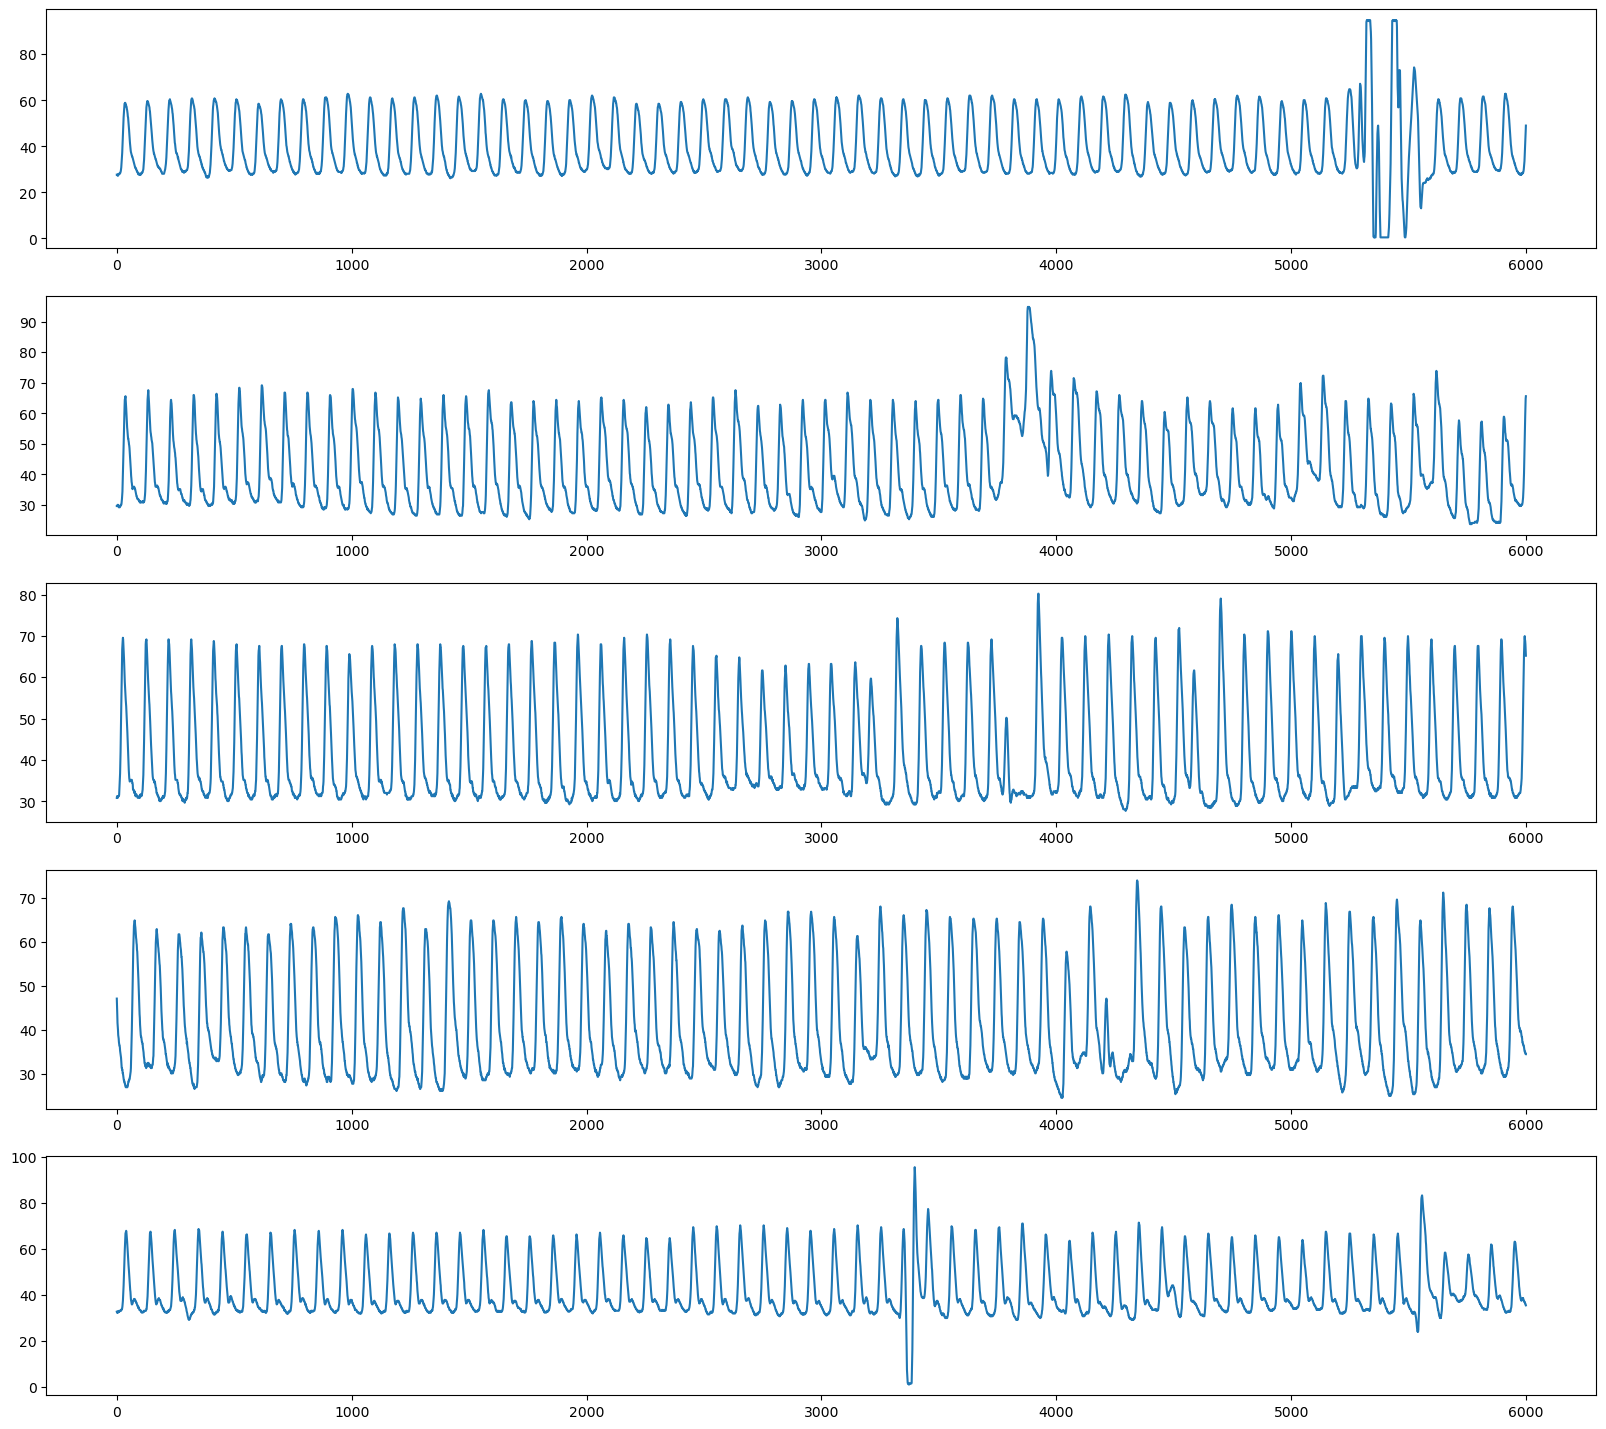

In [312]:
DataID = 128
plt.figure(figsize=(20,18))

plt.subplot(511)
plt.plot(TestDataSet[DataID])

plt.subplot(512)
plt.plot(TestDataSet[DataID+1])

plt.subplot(513)
plt.plot(TestDataSet[DataID+2])

plt.subplot(514)
plt.plot(TestDataSet[DataID+3])

plt.subplot(515)
plt.plot(TestDataSet[DataID+4])

plt.show()

In [304]:
dataID = 1625
result = check_ppg_abnormal(TestDataSet[dataID][2500:])
result

{'result': 1, 'reason': '최대 peak와 최소 peak 차이가 0.4 초과'}

In [53]:
dataID = 117
PPG = minmax_scale(TestDataSet[dataID])
normal   = PPG[:2500]
abnormal = PPG[2500:]

try:
    wd_p, _ = hp.process(normal, sample_rate=100) # peak 검출
except Exception:
    pass

pks_PPG = wd_p['peaklist'] # peak의 위치 리스트
pks_PPG = np.array(pks_PPG)
peak_dist_PPG = get_difference_list(pks_PPG) # peak 간격 리스트
differ_peak = get_difference_list(normal[pks_PPG])

std_peak_dist_PPG = np.std(peak_dist_PPG) # peak 간격의 std
std_peaks_PPG = np.std(normal[pks_PPG]) # peak 값의 std
std_differ_PPG = np.std(differ_peak)
max_min_differ = np.max(normal[pks_PPG]) - np.min(normal[pks_PPG])


P2PIDX =  np.concatenate([pks_PPG[:-1][..., np.newaxis], pks_PPG[1:][..., np.newaxis] ], axis=-1)
val_PPG =  np.unique([np.argmin(normal[i[0]:i[1]]) +i[0]  for i in P2PIDX])

valley_dist_PPG = get_difference_list(val_PPG) # valley 간격 리스트
std_valley_dist_PPG = np.std(valley_dist_PPG) # valley 간격의 std
std_valley_PPG = np.std(normal[val_PPG]) # valley 값의 std
differ_valley = get_difference_list(normal[val_PPG])

std_valleys_PPG = np.std(normal[val_PPG]) # peak 값의 std
std_differ_PPG_valley = np.std(differ_valley)
max_min_differ_valley = np.max(normal[val_PPG]) - np.min(normal[val_PPG])

print(f'dataID: {dataID}')
print('normal')
print()

print(f'peak 값의 std: {std_peaks_PPG}')
print(f'peak 간격의 std: {std_peak_dist_PPG}')
print(f'peak 최대 최소 차이: {max_min_differ}')
print(f'peak 간 차이 최대 값: {max(np.abs(differ_peak))}')
print(f'peak 개수: {len(pks_PPG)}')

print()
print(f'valley 값의 std: {std_valley_PPG}')
print(f'valley 간격의 std: {std_valley_dist_PPG}')
print(f'valley 최대 최소 차이: {max_min_differ_valley}')
print(f'valley 간 차이 최대 값: {max(np.abs(differ_valley))}')
print(f'valley 개수: {len(val_PPG)}')
print()

try:
    wd_p, _ = hp.process(abnormal, sample_rate=100) # peak 검출
except Exception:
    pass

pks_PPG = wd_p['peaklist'] # peak의 위치 리스트
pks_PPG = np.array(pks_PPG)
peak_dist_PPG = get_difference_list(pks_PPG) # peak 간격 리스트
differ_peak = get_difference_list(abnormal[pks_PPG])

std_peak_dist_PPG = np.std(peak_dist_PPG) # peak 간격의 std
std_peaks_PPG = np.std(abnormal[pks_PPG]) # peak 값의 std
std_differ_PPG = np.std(differ_peak)
max_min_differ = np.max(abnormal[pks_PPG]) - np.min(abnormal[pks_PPG])


P2PIDX =  np.concatenate([pks_PPG[:-1][..., np.newaxis], pks_PPG[1:][..., np.newaxis] ], axis=-1)
val_PPG =  np.unique([np.argmin(abnormal[i[0]:i[1]]) +i[0]  for i in P2PIDX])

valley_dist_PPG = get_difference_list(val_PPG) # valley 간격 리스트
std_valley_dist_PPG = np.std(valley_dist_PPG) # valley 간격의 std
std_valley_PPG = np.std(abnormal[val_PPG]) # valley 값의 std
differ_valley = get_difference_list(abnormal[val_PPG])

std_valleys_PPG = np.std(abnormal[val_PPG]) # peak 값의 std
std_differ_PPG_valley = np.std(differ_valley)
max_min_differ_valley = np.max(abnormal[val_PPG]) - np.min(abnormal[val_PPG])

print('abnormal')
print()

print(f'peak 값의 std: {std_peaks_PPG}')
print(f'peak 간격의 std: {std_peak_dist_PPG}')
print(f'peak 최대 최소 차이: {max_min_differ}')
print(f'peak 간 차이 최대 값: {max(np.abs(differ_peak))}')
print(f'peak 개수: {len(pks_PPG)}')

print()
print(f'valley 값의 std: {std_valley_PPG}')
print(f'valley 간격의 std: {std_valley_dist_PPG}')
print(f'valley 최대 최소 차이: {max_min_differ_valley}')
print(f'valley 간 차이 최대 값: {max(np.abs(differ_valley))}')
print(f'valley 개수: {len(val_PPG)}')

# print(f'reason: {Reasons[dataID]}')

dataID: 117
normal

peak 값의 std: 0.012626811558803745
peak 간격의 std: 1.1506953215302866
peak 최대 최소 차이: 0.041238993862858564
peak 간 차이 최대 값: 0.041238993862858564
peak 개수: 20

valley 값의 std: 0.006990511352697541
valley 간격의 std: 5.6031296369435415
valley 최대 최소 차이: 0.020616808652593743
valley 간 차이 최대 값: 0.020616808652593743
valley 개수: 19

abnormal

peak 값의 std: 0.014930967316068258
peak 간격의 std: 1.2876968840942817
peak 최대 최소 차이: 0.07216555098116695
peak 간 차이 최대 값: 0.06185590208133518
peak 개수: 29

valley 값의 std: 0.008289964981950558
valley 간격의 std: 33.58350565161195
valley 최대 최소 차이: 0.030926557118308384
valley 간 차이 최대 값: 0.020616808652593743
valley 개수: 28


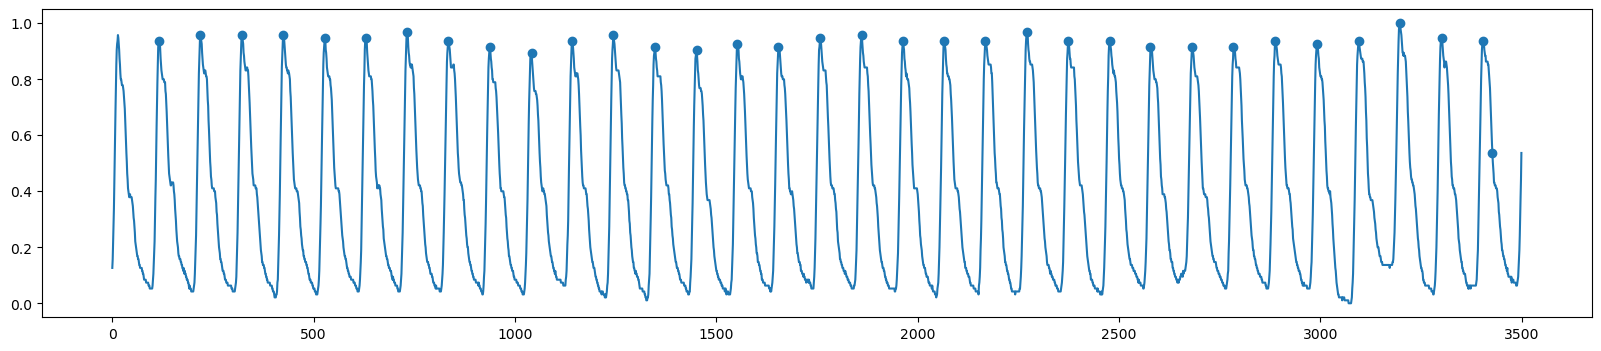

0.07086559998981509


In [305]:
DataID = 1625

PPG = minmax_scale(TestDataSet[DataID][2500:])

try:
    wd_p, _ = hp.process(PPG, sample_rate=100) # peak 검출
except Exception:
    pass


pks_PPG = wd_p['peaklist'] # peak의 위치 리스트
pks_PPG = np.array(pks_PPG)

plt.figure(figsize=(20,4))
plt.plot(PPG)
plt.scatter(pks_PPG, PPG[pks_PPG])

plt.show()

print(np.std(PPG[pks_PPG]))

In [318]:
a = np.load(path+ParaFolder+'/CleanSet1.npy',allow_pickle = True)
len(a)

25287